In [ ]:
import sys
import celloracle as co
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append('/project/jingshuw/SeqExpDesign/')
from seqpert.data_utils import DataSplitter

In [2]:
# Visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [3]:
adata = sc.read_h5ad("/project/jingshuw/SeqExpDesign/celloracle/celloracle_data/norman_umi_go/perturb_processed.h5ad")
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# Select top 2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=2000,
                                              log=False)

# Subset the genes
adata = adata[:, filter_result.gene_subset]

# Renormalize after filtering
sc.pp.normalize_per_cell(adata)

# keep raw cont data before log transformation
adata.raw = adata
adata.layers["raw_count"] = adata.raw.X.copy()

# Log transformation and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)

# PCA
print('PCA begins.')
sc.tl.pca(adata, svd_solver='arpack')
print('PCA done.')

# Diffusion map
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.diffmap(adata)

# Calculate neihbors again based on diffusionmap
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

print('louvain begins.')
sc.tl.louvain(adata=adata)
sc.tl.draw_graph(adata=adata)
adata.write("/project/jingshuw/SeqExpDesign/celloracle/celloracle_data/norman_umi_go/perturb_processed_2.h5ad")

PCA begins.
PCA done.
louvain begins.


In [7]:
adata = sc.read_h5ad("/project/jingshuw/SeqExpDesign/celloracle/celloracle_data/norman_umi_go/perturb_processed_train.h5ad")
base_GRN = pd.read_parquet('/project/jingshuw/SeqExpDesign/data/GSE140203/base_GRN_dataframe.parquet')
adata

AnnData object with n_obs × n_vars = 53928 × 1999
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'n_counts_all', 'n_counts', 'louvain', 'split'
    var: 'n_counts', 'mean', 'std', 'gene_id'
    uns: 'diffmap_evals', 'draw_graph', 'hvg', 'log1p', 'louvain', 'neighbors', 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'pca', 'rank_genes_groups_cov', 'rank_genes_groups_cov_all', 'rank_genes_groups_cov_top100', 'rank_genes_groups_cov_top200', 'rank_genes_groups_cov_top50', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'raw_count'
    obsp: 'connectivities', 'distances'

In [16]:
adata.var['gene_id'] = adata.var.index
adata.var.set_index('gene_name',inplace=True)

datasplitter = DataSplitter(adata=adata)
datasplitter.split_data(test_size=0.2, val_size=0.1,seed=42)

# Split the AnnData object based on the 'split' column in obs
adata_train = adata[adata.obs['split'] == 'train'].copy()
adata_test = adata[adata.obs['split'] == 'test'].copy()
adata_val = adata[adata.obs['split'] == 'val'].copy()

adata_train.write("/project/jingshuw/SeqExpDesign/celloracle/celloracle_data/norman_umi_go/perturb_processed_train.h5ad")
adata_test.write("/project/jingshuw/SeqExpDesign/celloracle/celloracle_data/norman_umi_go/perturb_processed_test.h5ad")
adata_val.write("/project/jingshuw/SeqExpDesign/celloracle/celloracle_data/norman_umi_go/perturb_processed_val.h5ad")


adata = adata_train

# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["counts"].copy()

... storing 'split' as categorical
... storing 'split' as categorical
... storing 'split' as categorical


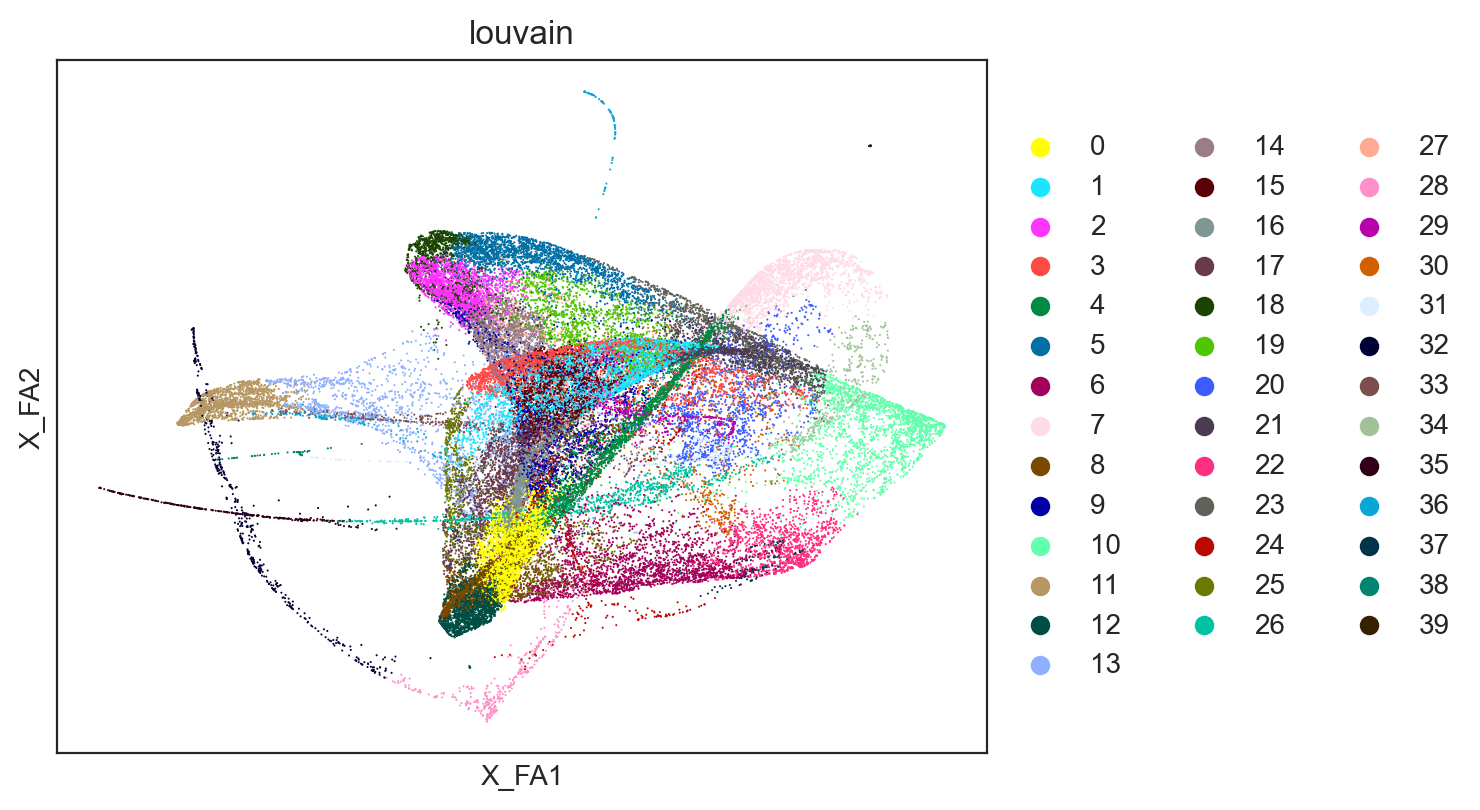

In [4]:
oracle = co.Oracle()


# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="louvain",
                                   embedding_name="X_draw_graph_fa")

# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [ ]:
# Perform PCA
oracle.perform_PCA()

# Save oracle object.
oracle.to_hdf5("/project/jingshuw/SeqExpDesign/celloracle/models/Norman_data.celloracle.oracle")

print('PCA done.')

# Load file.
oracle = co.load_hdf5("/project/jingshuw/SeqExpDesign/celloracle/models/Norman_data.celloracle.oracle")

# Select important PCs
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
print(n_comps)
n_comps = min(n_comps, 50)
n_comps = 1

# Set number of neighbors for KNN imputation
n_cell = oracle.adata.shape[0]
k = int(0.025 * n_cell)

# Perform KNN imputation
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)

# Save oracle object.
oracle.to_hdf5("/project/jingshuw/SeqExpDesign/celloracle/models/Norman_data.celloracle.oracle")
# Load file.
oracle = co.load_hdf5("/project/jingshuw/SeqExpDesign/celloracle/models/Norman_data.celloracle.oracle")

print('KNN done.')

15


In [ ]:
# Calculate GRN links
links = oracle.get_links(cluster_name_for_GRN_unit="louvain", alpha=10, verbose_level=10)
links.filter_links()

# Update Oracle with cluster-specific TF dictionary
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

In [7]:
# Save oracle object.
oracle.to_hdf5("/project/jingshuw/SeqExpDesign/celloracle/models/Norman_data_done.celloracle.oracle")